In [1]:
from __future__ import annotations

from pathlib import Path
from datetime import date
from collections import Counter
import glob
import gc

import polars as pl
import matplotlib.pyplot as plt


In [2]:
# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "blocks": str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"),
    "txs":    str(PARQUET_DIR / "txs/day=*/txs-*.parquet"),
    "io":     str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

print("Parquet file counts:", {k: len(glob.glob(v)) for k, v in patterns.items()})

CUTOFF_DAY = date(2013, 1, 1)

Parquet file counts: {'blocks': 7713, 'txs': 7713, 'io': 7678}


In [3]:
# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    """
    Given a path like /.../io/day=2013-05-01/io-0001.parquet
    return date(2013, 5, 1).
    """
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(self, x: int, y: int) -> None:
        rx = self.find(x)
        ry = self.find(y)
        if rx == ry:
            return

        parent = self.parent
        rank = self.rank

        if rank[rx] < rank[ry]:
            parent[rx] = ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
        else:
            parent[ry] = rx
            rank[rx] += 1


def addr_type(addr: str) -> str:
    """Rough address type from prefix (legacy P2PKH, P2SH, Bech32, Taproot, etc.)."""
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def detect_coinjoin_like(n_in: int, out_values: list[float]) -> bool:
    """
    Very simple CoinJoin-ish heuristic:
    - at least 3 inputs
    - at least 3 outputs
    - at least 3 outputs with exactly the same value
    """
    n_out = len(out_values)
    if n_in < 3 or n_out < 3:
        return False
    cnt = Counter(out_values)
    max_eq = max(cnt.values())
    return max_eq >= 3


In [4]:
# -----------------------------
# Init structures
# -----------------------------
io_paths = sorted(glob.glob(patterns["io"]))
print(f"Found {len(io_paths)} io parquet files.")

uf = UnionFind()
addr_to_id: dict[str, int] = {}  # address -> union-find node index

# RAM-friendly flags indexed by node_id:
# seen_output_flags[i] == 1 if address i was ever seen as a vout
# multi_change_flags[i] bit 0 -> multi-input, bit 1 -> change
seen_output_flags = bytearray()
multi_change_flags = bytearray()

# For coverage / stats
n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0

Found 7678 io parquet files.


In [5]:
# -----------------------------
# Build final entity mapping
# -----------------------------
print("Finalizing entity mapping (compressing components)...")

# Map each node to its root
node_to_root: dict[int, int] = {}
for addr, node_id in addr_to_id.items():
    root = uf.find(node_id)
    node_to_root[node_id] = root

# Map each root to a compact entity_id (0..N-1)
root_to_entity: dict[int, int] = {}
next_entity_id = 0
entity_ids: list[int] = []

for addr, node_id in addr_to_id.items():
    root = node_to_root[node_id]
    ent = root_to_entity.get(root)
    if ent is None:
        ent = next_entity_id
        root_to_entity[root] = ent
        next_entity_id += 1
    entity_ids.append(ent)

print(f"Number of unique addresses (2013+): {len(addr_to_id)}")
print(f"Number of entities (clusters): {next_entity_id}")

Finalizing entity mapping (compressing components)...
Number of unique addresses (2013+): 0
Number of entities (clusters): 0


In [6]:
entities_df = pl.DataFrame(
    {
        "address": list(addr_to_id.keys()),
        "entity_id": entity_ids,
    }
)

out_path = OUTPUT_DIR / "entities_multiinput_change_singleton_2013_onward.parquet"
entities_df.write_parquet(out_path)
print(f"Saved entity mapping to: {out_path}")


Saved entity mapping to: /media/vatereal/Main/outputs/entities_multiinput_change_singleton_2013_onward.parquet


In [7]:
def ensure_flag_capacity(idx: int) -> None:
    """
    Make sure flag arrays are at least as long as needed for node_id idx.
    """
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    """Map address string to union-find index (create if new, plus flag slots)."""
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


In [ ]:

# -----------------------------
# Main pass over IO parquet files
# -----------------------------
for i, path in enumerate(io_paths, start=1):
    file_day = extract_day_from_path(path)
    if file_day is None:
        print(f"[{i}/{len(io_paths)}] WARNING: could not extract day from path, skipping: {path}")
        continue

    # Skip data before 2013-01-01
    if file_day < CUTOFF_DAY:
        continue

    print(f"[{i}/{len(io_paths)}] Processing {path} (day={file_day}) ...")

    # Read only columns we need (saves RAM)
    df = pl.read_parquet(path, columns=["dir", "txid", "address", "value"])

    # Filter only non-null addresses
    df = (
        df
        .filter(pl.col("address").is_not_null())
        .select(["dir", "txid", "address", "value"])
    )

    if df.height == 0:
        del df
        gc.collect()
        continue

    # --- Ensure every address gets a node_id (singleton by default) ---
    unique_addrs = df.select(pl.col("address").unique())["address"].to_list()
    for a in unique_addrs:
        get_addr_id(a)
    del unique_addrs
    gc.collect()

    # Split into inputs and outputs
    vin_df = (
        df
        .filter(pl.col("dir") == "vin")
        .group_by("txid")
        .agg(
            pl.col("address").unique().alias("in_addrs")
        )
    )

    vout_df = (
        df
        .filter(pl.col("dir") == "vout")
        .group_by("txid")
        .agg(
            pl.col("address").alias("out_addrs"),   # keep duplicates if same address repeated
            pl.col("value").alias("out_values")
        )
    )

    # df no longer needed
    del df
    gc.collect()

    # Join inputs & outputs per txid
    tx_df = vin_df.join(vout_df, on="txid", how="inner")

    # free vin/vout to save RAM
    del vin_df, vout_df
    gc.collect()

    if tx_df.height == 0:
        del tx_df
        gc.collect()
        continue

    # Iterate over transactions
    for row in tx_df.iter_rows(named=True):
        in_addrs: list[str] = row["in_addrs"]
        out_addrs: list[str] = row["out_addrs"]
        out_values: list[float] = row["out_values"]

        if not in_addrs or not out_addrs:
            continue

        n_txs_total += 1

        n_in = len(in_addrs)
        n_out = len(out_addrs)

        # CoinJoin/mixer-like detection: skip these txs for heuristics
        is_coinjoin = detect_coinjoin_like(n_in, out_values)
        if is_coinjoin:
            n_txs_coinjoin_flagged += 1
            # still mark outputs as seen
            for a in out_addrs:
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
            continue

        # --- Multi-input heuristic ---
        if n_in >= 2:
            n_txs_with_multiinput += 1

            in_ids = [get_addr_id(a) for a in in_addrs]
            for idx in in_ids:
                multi_change_flags[idx] |= 1  # mark as multi-input

            first_id = in_ids[0]
            for idx in in_ids[1:]:
                uf.union(first_id, idx)

        # --- Change-address heuristic ---
        if n_in >= 1 and n_out >= 2:
            in_types = [addr_type(a) for a in in_addrs]
            type_counts = Counter(in_types)
            majority_type = max(type_counts, key=type_counts.get)

            candidates: list[str] = []
            for a in out_addrs:
                if a in in_addrs:
                    continue
                if addr_type(a) != majority_type:
                    continue
                a_id = get_addr_id(a)
                if seen_output_flags[a_id]:
                    # stricter: favor new output addresses
                    continue
                candidates.append(a)

            if len(candidates) == 1:
                change_addr = candidates[0]
                change_id = get_addr_id(change_addr)
                multi_change_flags[change_id] |= 2  # mark as change

                n_txs_with_change_detected += 1

                first_input_id = get_addr_id(in_addrs[0])
                uf.union(first_input_id, change_id)

        # mark all outputs as seen for future change detection
        for a in out_addrs:
            a_id = get_addr_id(a)
            seen_output_flags[a_id] = 1

    # free tx_df at end of this file
    del tx_df
    gc.collect()


[1498/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
[1499/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[1500/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[1501/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000215033-000215039.parquet (day=2013-01-03) ...
[1502/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-04/io-000215040-000215192.parquet (day=2013-01-04) ...
[1503/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-05/io-000215193-000215333.parquet (day=2013-01-05) ...
[1504/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-06/io-000215334-000215478.parquet (day=2013-01-06) ...
[1505/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-07/io-000215479-000215646.parquet (day=2013-01-07) ...
[1506/7678] Processing /

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7a17f939bfe0>>
Traceback (most recent call last):
  File "/home/vatereal/.cache/pypoetry/virtualenvs/blockchain-MbR7oPYh-py3.12/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


[2016/7678] Processing /media/vatereal/Main/parquet/io/day=2014-05-16/io-000300936-000301116.parquet (day=2014-05-16) ...
[2017/7678] Processing /media/vatereal/Main/parquet/io/day=2014-05-17/io-000301117-000301289.parquet (day=2014-05-17) ...
[2018/7678] Processing /media/vatereal/Main/parquet/io/day=2014-05-18/io-000301290-000301461.parquet (day=2014-05-18) ...
[2019/7678] Processing /media/vatereal/Main/parquet/io/day=2014-05-19/io-000301462-000301629.parquet (day=2014-05-19) ...
[2020/7678] Processing /media/vatereal/Main/parquet/io/day=2014-05-20/io-000301630-000301806.parquet (day=2014-05-20) ...
[2021/7678] Processing /media/vatereal/Main/parquet/io/day=2014-05-21/io-000301807-000301981.parquet (day=2014-05-21) ...
[2022/7678] Processing /media/vatereal/Main/parquet/io/day=2014-05-22/io-000301982-000302153.parquet (day=2014-05-22) ...
[2023/7678] Processing /media/vatereal/Main/parquet/io/day=2014-05-23/io-000302154-000302318.parquet (day=2014-05-23) ...
[2024/7678] Processing /

In [ ]:
# -----------------------------
# Build final entity mapping
# -----------------------------
print("Finalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses (2013+): {n_nodes}")

if n_nodes == 0:
    print("No addresses found after 2013-01-01. Nothing to cluster.")
else:
    # Map each node -> entity id via connected components
    node_to_entity = [0] * n_nodes
    root_to_entity: dict[int, int] = {}
    next_entity_id = 0

    for node in range(n_nodes):
        root = uf.find(node)
        ent = root_to_entity.get(root)
        if ent is None:
            ent = next_entity_id
            root_to_entity[root] = ent
            next_entity_id += 1
        node_to_entity[node] = ent

    print(f"Number of entities (clusters): {next_entity_id}")

    # Compute cluster sizes directly from node_to_entity
    cluster_size_counter = Counter(node_to_entity)
    cluster_sizes = list(cluster_size_counter.values())

    n_entities = len(cluster_size_counter)
    n_singletons = sum(1 for s in cluster_sizes if s == 1)
    n_large = sum(1 for s in cluster_sizes if s >= 10)

    # Build output lists (address, entity_id)
    addresses_out: list[str] = []
    entity_ids_out: list[int] = []

    for addr, node_id in addr_to_id.items():
        addresses_out.append(addr)
        entity_ids_out.append(node_to_entity[node_id])

    entities_df = pl.DataFrame(
        {
            "address": addresses_out,
            "entity_id": entity_ids_out,
        }
    )

    out_path = OUTPUT_DIR / "entities_multiinput_change_singleton_2013_onward.parquet"
    entities_df.write_parquet(out_path)
    print(f"Saved entity mapping to: {out_path}")

    # We no longer need the address dict; other large structures will be GC'ed soon anyway
    del addr_to_id
    gc.collect()

    # -----------------------------
    # Basic stats & plots
    # -----------------------------
    # Heuristic coverage (address-level)
    n_addrs_total = n_nodes
    # For safety, only consider first n_nodes entries in the flag arrays
    flags_view = multi_change_flags[:n_nodes]

    n_addrs_multi = sum(1 for v in flags_view if (v & 1))
    n_addrs_change = sum(1 for v in flags_view if (v & 2))
    n_addrs_touched = sum(1 for v in flags_view if (v & 3))
    n_addrs_only_singleton = n_addrs_total - n_addrs_touched

    print("Computing cluster size statistics...")

    print(f"Total entities: {n_entities}")
    print(f"Singleton entities (size=1): {n_singletons}")
    print(f"Entities with size >= 10: {n_large}")

    print("\nHeuristic coverage:")
    print(f"  Total txs processed (with both vin & vout): {n_txs_total}")
    print(f"  Txs flagged as CoinJoin-like (skipped): {n_txs_coinjoin_flagged}")
    print(f"  Txs using multi-input heuristic: {n_txs_with_multiinput}")
    print(f"  Txs with change-address detected: {n_txs_with_change_detected}")
    print(f"  Addresses in multi-input txs (unique): {n_addrs_multi}")
    print(f"  Addresses detected as change (unique): {n_addrs_change}")
    print(f"  Addresses only in singleton entities: {n_addrs_only_singleton}")


In [ ]:
    # ---- Plot 1: cluster size distribution ----
    if any(s > 0 for s in cluster_sizes):
        plt.figure(figsize=(8, 5))
        plt.hist(cluster_sizes, bins=100, log=True)
        plt.xlabel("Cluster size (number of addresses in entity)")
        plt.ylabel("Frequency (log scale)")
        plt.title("Distribution of Bitcoin Entity Cluster Sizes (2013+)")
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("No positive cluster sizes to plot (cluster size histogram skipped).")

    # ---- Plot 2: heuristic coverage (address-level) ----
    if n_addrs_total > 0:
        plt.figure(figsize=(6, 4))
        plt.bar(
            ["multi-input\n(addrs)", "change\n(addrs)", "only\nsingleton"],
            [n_addrs_multi, n_addrs_change, n_addrs_only_singleton],
        )
        plt.ylabel("Number of addresses")
        plt.title("Heuristic Coverage of Addresses (2013+)")
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("No addresses to plot (heuristic coverage bar chart skipped).")


In [ ]:
from __future__ import annotations

from pathlib import Path
from datetime import date
from collections import Counter
import glob
import gc  # for explicit garbage collection

import polars as pl
import matplotlib.pyplot as plt

# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "blocks": str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"),
    "txs":    str(PARQUET_DIR / "txs/day=*/txs-*.parquet"),
    "io":     str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

print("Parquet file counts:", {k: len(glob.glob(v)) for k, v in patterns.items()})

# Only cluster for data on/after this day
CUTOFF_DAY = date(2013, 1, 1)

# Treat these dir values as outputs; everything else will be treated as inputs
OUTPUT_DIR_VALUES = {"vout", "out", "output", "o"}

# Whether to create a union-find node for every address seen
# (even if that address never appears in a multi-input/change tx).
# This guarantees you get a mapping for all addresses, at the cost of more RAM.
PRECREATE_NODES_FOR_ALL_ADDRS = True

# For plotting, don't try to histogram if there are too many entities
MAX_ENTITIES_FOR_PLOT = 5_000_000

# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    """
    Given a path like /.../io/day=2013-05-01/io-0001.parquet
    return date(2013, 5, 1).
    """
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(self, x: int, y: int) -> None:
        rx = self.find(x)
        ry = self.find(y)
        if rx == ry:
            return

        parent = self.parent
        rank = self.rank

        if rank[rx] < rank[ry]:
            parent[rx] = ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
        else:
            parent[ry] = rx
            rank[rx] += 1


def addr_type(addr: str) -> str:
    """Rough address type from prefix (legacy P2PKH, P2SH, Bech32, Taproot, etc.)."""
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def detect_coinjoin_like(n_in: int, out_values: list[float]) -> bool:
    """
    Very simple CoinJoin-ish heuristic:
    - at least 3 inputs
    - at least 3 outputs
    - at least 3 outputs with exactly the same value
    """
    n_out = len(out_values)
    if n_in < 3 or n_out < 3:
        return False
    cnt = Counter(out_values)
    max_eq = max(cnt.values())
    return max_eq >= 3


# -----------------------------
# Init structures
# -----------------------------
io_paths = sorted(glob.glob(patterns["io"]))
print(f"Found {len(io_paths)} io parquet files.")

uf = UnionFind()
addr_to_id: dict[str, int] = {}  # address -> union-find node index

# RAM-friendly flags indexed by node_id:
# seen_output_flags[i] == 1 if address i was ever seen as a vout
# multi_change_flags[i] bit 0 -> multi-input, bit 1 -> change
seen_output_flags = bytearray()
multi_change_flags = bytearray()

# For coverage / stats
n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0


def ensure_flag_capacity(idx: int) -> None:
    """
    Make sure flag arrays are at least as long as needed for node_id idx.
    """
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    """Map address string to union-find index (create if new, plus flag slots)."""
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


# -----------------------------
# Main pass over IO parquet files
# -----------------------------
for i, path in enumerate(io_paths, start=1):
    file_day = extract_day_from_path(path)
    if file_day is None:
        print(f"[{i}/{len(io_paths)}] WARNING: could not extract day from path, skipping: {path}")
        continue

    # Skip data before CUTOFF_DAY
    if file_day < CUTOFF_DAY:
        continue

    print(f"[{i}/{len(io_paths)}] Processing {path} (day={file_day}) ...")

    # Read only columns we need (saves RAM)
    df = pl.read_parquet(path, columns=["dir", "txid", "address", "value"])

    # Normalize dir to lowercase UTF-8 strings
    df = df.with_columns(
        pl.col("dir")
        .cast(pl.Utf8)
        .str.to_lowercase()
        .alias("dir")
    )

    # Filter only non-null dir and non-null addresses
    df = (
        df
        .filter(pl.col("dir").is_not_null())
        .filter(pl.col("address").is_not_null())
        .select(["dir", "txid", "address", "value"])
    )

    if df.height == 0:
        del df
        gc.collect()
        continue

    # Optional: print distinct dir values for the first few files to sanity-check encoding
    if i <= 3:
        dir_uniques = df.select(pl.col("dir").unique()).to_series().to_list()
        print(f"  [debug] distinct dir values in this file: {dir_uniques}")

    # --- Optionally ensure every address gets a node_id (singleton by default) ---
    if PRECREATE_NODES_FOR_ALL_ADDRS:
        unique_addrs = df.select(pl.col("address").unique()).to_series().to_list()
        for a in unique_addrs:
            get_addr_id(a)
        del unique_addrs
        gc.collect()

    # Split into inputs and outputs:
    # - outputs: dir in OUTPUT_DIR_VALUES
    # - inputs : everything else
    vin_df = (
        df
        .filter(~pl.col("dir").is_in(list(OUTPUT_DIR_VALUES)))
        .group_by("txid")
        .agg(
            pl.col("address").unique().alias("in_addrs")
        )
    )

    vout_df = (
        df
        .filter(pl.col("dir").is_in(list(OUTPUT_DIR_VALUES)))
        .group_by("txid")
        .agg(
            pl.col("address").alias("out_addrs"),   # keep duplicates if same address repeated
            pl.col("value").alias("out_values")
        )
    )

    # df no longer needed
    del df
    gc.collect()

    if vin_df.height == 0 or vout_df.height == 0:
        # No txs with both inputs and outputs in this file
        del vin_df, vout_df
        gc.collect()
        continue

    # Join inputs & outputs per txid
    tx_df = vin_df.join(vout_df, on="txid", how="inner")

    # free vin/vout to save RAM
    del vin_df, vout_df
    gc.collect()

    if tx_df.height == 0:
        del tx_df
        gc.collect()
        continue

    # Iterate over transactions
    for row in tx_df.iter_rows(named=True):
        in_addrs: list[str] = row["in_addrs"]
        out_addrs: list[str] = row["out_addrs"]
        out_values: list[float] = row["out_values"]

        if not in_addrs or not out_addrs:
            continue

        n_txs_total += 1

        n_in = len(in_addrs)
        n_out = len(out_addrs)

        # CoinJoin/mixer-like detection: skip these txs for heuristics
        is_coinjoin = detect_coinjoin_like(n_in, out_values)
        if is_coinjoin:
            n_txs_coinjoin_flagged += 1
            # still mark outputs as seen
            for a in out_addrs:
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
            continue

        # --- Multi-input heuristic ---
        if n_in >= 2:
            n_txs_with_multiinput += 1

            in_ids = [get_addr_id(a) for a in in_addrs]
            for idx in in_ids:
                multi_change_flags[idx] |= 1  # mark as multi-input

            first_id = in_ids[0]
            for idx in in_ids[1:]:
                uf.union(first_id, idx)

        # --- Change-address heuristic ---
        if n_in >= 1 and n_out >= 2:
            in_types = [addr_type(a) for a in in_addrs]
            type_counts = Counter(in_types)
            majority_type = max(type_counts, key=type_counts.get)

            candidates: list[str] = []
            for a in out_addrs:
                if a in in_addrs:
                    continue
                if addr_type(a) != majority_type:
                    continue
                a_id = get_addr_id(a)
                if seen_output_flags[a_id]:
                    # stricter: favor new output addresses
                    continue
                candidates.append(a)

            if len(candidates) == 1:
                change_addr = candidates[0]
                change_id = get_addr_id(change_addr)
                multi_change_flags[change_id] |= 2  # mark as change

                n_txs_with_change_detected += 1

                first_input_id = get_addr_id(in_addrs[0])
                uf.union(first_input_id, change_id)

        # mark all outputs as seen for future change detection
        for a in out_addrs:
            a_id = get_addr_id(a)
            seen_output_flags[a_id] = 1

    # free tx_df at end of this file
    del tx_df
    gc.collect()

# -----------------------------
# Build final entity mapping
# -----------------------------
print("Finalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with entity nodes (2013+): {n_nodes}")

if n_nodes == 0:
    print("No addresses ended up with union-find nodes. This likely means either:")
    print("  - No transactions had both input and output addresses detected, and")
    print("  - PRECREATE_NODES_FOR_ALL_ADDRS is False, or")
    print("  - Your 'dir' encoding is such that all rows are treated as outputs.")
else:
    # Map each node -> entity id via connected components
    node_to_entity = [0] * n_nodes
    root_to_entity: dict[int, int] = {}
    next_entity_id = 0

    for node in range(n_nodes):
        root = uf.find(node)
        ent = root_to_entity.get(root)
        if ent is None:
            ent = next_entity_id
            root_to_entity[root] = ent
            next_entity_id += 1
        node_to_entity[node] = ent

    print(f"Number of entities (clusters): {next_entity_id}")

    # Compute cluster sizes directly from node_to_entity
    cluster_size_counter = Counter(node_to_entity)
    n_entities = len(cluster_size_counter)

    # For stats:
    if n_entities <= MAX_ENTITIES_FOR_PLOT:
        cluster_sizes = list(cluster_size_counter.values())
        n_singletons = sum(1 for s in cluster_sizes if s == 1)
        n_large = sum(1 for s in cluster_sizes if s >= 10)
    else:
        # Avoid materializing a giant list just for plotting
        cluster_sizes = None
        n_singletons = sum(1 for s in cluster_size_counter.values() if s == 1)
        n_large = sum(1 for s in cluster_size_counter.values() if s >= 10)

    # Build output lists (address, entity_id)
    addresses_out: list[str] = []
    entity_ids_out: list[int] = []

    for addr, node_id in addr_to_id.items():
        addresses_out.append(addr)
        entity_ids_out.append(node_to_entity[node_id])

    entities_df = pl.DataFrame(
        {
            "address": addresses_out,
            "entity_id": entity_ids_out,
        }
    )

    out_path = OUTPUT_DIR / "entities_multiinput_change_singleton_2013_onward.parquet"
    entities_df.write_parquet(out_path)
    print(f"Saved entity mapping to: {out_path}")

    # We no longer need the address dict; other large structures will be GC'ed soon anyway
    del addr_to_id, node_to_entity, addresses_out, entity_ids_out
    gc.collect()

    # -----------------------------
    # Basic stats & plots
    # -----------------------------
    # Heuristic coverage (address-level)
    n_addrs_total = n_nodes
    # For safety, only consider first n_nodes entries in the flag arrays
    flags_view = multi_change_flags[:n_nodes]

    n_addrs_multi = sum(1 for v in flags_view if (v & 1))
    n_addrs_change = sum(1 for v in flags_view if (v & 2))
    n_addrs_touched = sum(1 for v in flags_view if (v & 3))
    n_addrs_only_singleton = n_addrs_total - n_addrs_touched

    print("Computing cluster size statistics...")

    print(f"Total entities: {n_entities}")
    print(f"Singleton entities (size=1): {n_singletons}")
    print(f"Entities with size >= 10: {n_large}")

    print("\nHeuristic coverage:")
    print(f"  Total txs processed (with both vin & vout): {n_txs_total}")
    print(f"  Txs flagged as CoinJoin-like (skipped): {n_txs_coinjoin_flagged}")
    print(f"  Txs using multi-input heuristic: {n_txs_with_multiinput}")
    print(f"  Txs with change-address detected: {n_txs_with_change_detected}")
    print(f"  Addresses in multi-input txs (unique): {n_addrs_multi}")
    print(f"  Addresses detected as change (unique): {n_addrs_change}")
    print(f"  Addresses only in singleton entities: {n_addrs_only_singleton}")

    # ---- Plot 1: cluster size distribution ----
    if cluster_sizes is not None and any(s > 0 for s in cluster_sizes):
        plt.figure(figsize=(8, 5))
        plt.hist(cluster_sizes, bins=100, log=True)
        plt.xlabel("Cluster size (number of addresses in entity)")
        plt.ylabel("Frequency (log scale)")
        plt.title("Distribution of Bitcoin Entity Cluster Sizes (2013+)")
        plt.tight_layout()
        plt.show()
        plt.close()
    elif cluster_sizes is None:
        print(f"Skipping cluster size histogram (too many entities > {MAX_ENTITIES_FOR_PLOT}).")
    else:
        print("No positive cluster sizes to plot (cluster size histogram skipped).")

    # ---- Plot 2: heuristic coverage (address-level) ----
    if n_addrs_total > 0:
        plt.figure(figsize=(6, 4))
        plt.bar(
            ["multi-input\n(addrs)", "change\n(addrs)", "only\nsingleton"],
            [n_addrs_multi, n_addrs_change, n_addrs_only_singleton],
        )
        plt.ylabel("Number of addresses")
        plt.title("Heuristic Coverage of Addresses (2013+)")
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("No addresses to plot (heuristic coverage bar chart skipped).")


Parquet file counts: {'blocks': 7713, 'txs': 7713, 'io': 7678}
Found 7678 io parquet files.
[1498/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
[1499/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[1500/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[1501/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000215033-000215039.parquet (day=2013-01-03) ...
[1502/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-04/io-000215040-000215192.parquet (day=2013-01-04) ...
[1503/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-05/io-000215193-000215333.parquet (day=2013-01-05) ...
[1504/7678] Processing /media/vatereal/Main/parquet/io/day=2013-01-06/io-000215334-000215478.parquet (day=2013-01-06) ...
[1505/7678] Processing /media/vatereal/Main/parquet/io

KeyboardInterrupt: 

Parquet file counts: {'blocks': 7713, 'txs': 7713, 'io': 7678}
[INFO] Analysis window: 2013-01-01 .. 2014-01-01 (exclusive)
Found 7678 io parquet files (all years).
[1] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
  [debug] distinct dir values in first processed file: ['out']
[2] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[3] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000214878-000215032.parquet (day=2013-01-03) ...
[4] Processing /media/vatereal/Main/parquet/io/day=2013-01-03/io-000215033-000215039.parquet (day=2013-01-03) ...
[5] Processing /media/vatereal/Main/parquet/io/day=2013-01-04/io-000215040-000215192.parquet (day=2013-01-04) ...
[6] Processing /media/vatereal/Main/parquet/io/day=2013-01-05/io-000215193-000215333.parquet (day=2013-01-05) ...
[7] Processing /media/vatereal/Main/parquet/io/day=2013-01-06/io-000215334-000215478.par

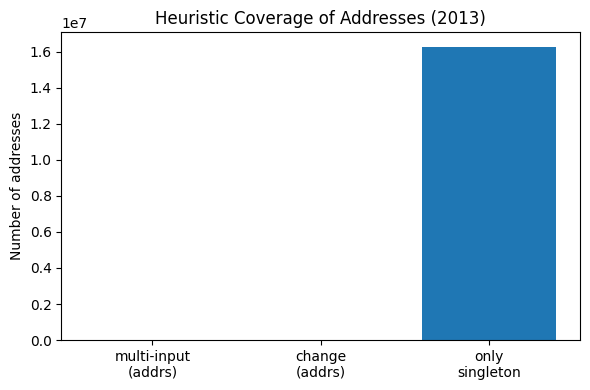

In [2]:
from __future__ import annotations

from pathlib import Path
from datetime import date
from collections import Counter
import glob
import gc  # for explicit garbage collection

import polars as pl
import matplotlib.pyplot as plt

# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "blocks": str(PARQUET_DIR / "blocks/day=*/blocks-*.parquet"),
    "txs":    str(PARQUET_DIR / "txs/day=*/txs-*.parquet"),
    "io":     str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

print("Parquet file counts:", {k: len(glob.glob(v)) for k, v in patterns.items()})

# -----------------------------
# YEAR SELECTION (single year only)
# -----------------------------
ANALYSIS_YEAR = 2013  # <-- change to 2014 for the next run

START_DAY = date(ANALYSIS_YEAR, 1, 1)
END_DAY = date(ANALYSIS_YEAR + 1, 1, 1)  # exclusive

print(f"[INFO] Analysis window: {START_DAY} .. {END_DAY} (exclusive)")

# Treat these dir values as outputs; everything else will be treated as inputs
OUTPUT_DIR_VALUES = {"vout", "out", "output", "o"}

# Whether to create a union-find node for every address seen in the year
PRECREATE_NODES_FOR_ALL_ADDRS = True

# For plotting, don't try to histogram if there are too many entities
MAX_ENTITIES_FOR_PLOT = 5_000_000

# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    """
    Given a path like /.../io/day=2013-05-01/io-0001.parquet
    return date(2013, 5, 1).
    """
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(self, x: int, y: int) -> None:
        rx = self.find(x)
        ry = self.find(y)
        if rx == ry:
            return

        parent = self.parent
        rank = self.rank

        if rank[rx] < rank[ry]:
            parent[rx] = ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
        else:
            parent[ry] = rx
            rank[rx] += 1


def addr_type(addr: str) -> str:
    """Rough address type from prefix (legacy P2PKH, P2SH, Bech32, Taproot, etc.)."""
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def detect_coinjoin_like(n_in: int, out_values: list[float]) -> bool:
    """
    Very simple CoinJoin-ish heuristic:
    - at least 3 inputs
    - at least 3 outputs
    - at least 3 outputs with exactly the same value
    """
    n_out = len(out_values)
    if n_in < 3 or n_out < 3:
        return False
    cnt = Counter(out_values)
    return max(cnt.values()) >= 3


# -----------------------------
# Init structures
# -----------------------------
io_paths = sorted(glob.glob(patterns["io"]))
print(f"Found {len(io_paths)} io parquet files (all years).")

uf = UnionFind()
addr_to_id: dict[str, int] = {}  # address -> union-find node index

# RAM-friendly flags indexed by node_id:
# seen_output_flags[i] == 1 if address i was ever seen as a vout
# multi_change_flags[i] bit 0 -> multi-input, bit 1 -> change
seen_output_flags = bytearray()
multi_change_flags = bytearray()

# For coverage / stats
n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0


def ensure_flag_capacity(idx: int) -> None:
    """Make sure flag arrays are at least as long as needed for node_id idx."""
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    """Map address string to union-find index (create if new, plus flag slots)."""
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


# -----------------------------
# Main pass over IO parquet files (single year only)
# -----------------------------
n_considered = 0
n_processed = 0

for i, path in enumerate(io_paths, start=1):
    file_day = extract_day_from_path(path)
    if file_day is None:
        continue

    # Keep only files inside the analysis window
    if not (START_DAY <= file_day < END_DAY):
        continue

    n_considered += 1
    print(f"[{n_considered}] Processing {path} (day={file_day}) ...")

    # Read only columns we need
    df = pl.read_parquet(path, columns=["dir", "txid", "address", "value"])

    # Normalize dir
    df = df.with_columns(
        pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir")
    )

    # Filter only non-null dir and addresses
    df = (
        df
        .filter(pl.col("dir").is_not_null())
        .filter(pl.col("address").is_not_null())
        .select(["dir", "txid", "address", "value"])
    )

    if df.height == 0:
        del df
        gc.collect()
        continue

    n_processed += 1

    # Optional debug on first processed file of the year
    if n_processed == 1:
        dir_uniques = df.select(pl.col("dir").unique()).to_series().to_list()
        print(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

    # Precreate nodes for all addresses seen (year-only)
    if PRECREATE_NODES_FOR_ALL_ADDRS:
        unique_addrs = df.select(pl.col("address").unique()).to_series().to_list()
        for a in unique_addrs:
            get_addr_id(a)
        del unique_addrs
        gc.collect()

    # Split into inputs and outputs
    vin_df = (
        df
        .filter(~pl.col("dir").is_in(list(OUTPUT_DIR_VALUES)))
        .group_by("txid")
        .agg(pl.col("address").unique().alias("in_addrs"))
    )

    vout_df = (
        df
        .filter(pl.col("dir").is_in(list(OUTPUT_DIR_VALUES)))
        .group_by("txid")
        .agg(
            pl.col("address").alias("out_addrs"),
            pl.col("value").alias("out_values"),
        )
    )

    del df
    gc.collect()

    if vin_df.height == 0 or vout_df.height == 0:
        del vin_df, vout_df
        gc.collect()
        continue

    tx_df = vin_df.join(vout_df, on="txid", how="inner")
    del vin_df, vout_df
    gc.collect()

    if tx_df.height == 0:
        del tx_df
        gc.collect()
        continue

    for row in tx_df.iter_rows(named=True):
        in_addrs: list[str] = row["in_addrs"]
        out_addrs: list[str] = row["out_addrs"]
        out_values: list[float] = row["out_values"]

        if not in_addrs or not out_addrs:
            continue

        n_txs_total += 1
        n_in = len(in_addrs)
        n_out = len(out_addrs)

        # CoinJoin-like detection
        if detect_coinjoin_like(n_in, out_values):
            n_txs_coinjoin_flagged += 1
            for a in out_addrs:
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
            continue

        # Multi-input heuristic
        if n_in >= 2:
            n_txs_with_multiinput += 1
            in_ids = [get_addr_id(a) for a in in_addrs]
            for idx in in_ids:
                multi_change_flags[idx] |= 1
            first_id = in_ids[0]
            for idx in in_ids[1:]:
                uf.union(first_id, idx)

        # Change heuristic
        if n_in >= 1 and n_out >= 2:
            in_types = [addr_type(a) for a in in_addrs]
            majority_type = max(Counter(in_types), key=Counter(in_types).get)

            candidates: list[str] = []
            in_set = set(in_addrs)  # speed-up membership checks
            for a in out_addrs:
                if a in in_set:
                    continue
                if addr_type(a) != majority_type:
                    continue
                a_id = get_addr_id(a)
                if seen_output_flags[a_id]:
                    continue
                candidates.append(a)

            if len(candidates) == 1:
                change_addr = candidates[0]
                change_id = get_addr_id(change_addr)
                multi_change_flags[change_id] |= 2
                n_txs_with_change_detected += 1
                uf.union(get_addr_id(in_addrs[0]), change_id)

        # Mark outputs as seen
        for a in out_addrs:
            a_id = get_addr_id(a)
            seen_output_flags[a_id] = 1

    del tx_df
    gc.collect()

print(f"[INFO] Files considered in {ANALYSIS_YEAR}: {n_considered}")
print(f"[INFO] Non-empty files processed in {ANALYSIS_YEAR}: {n_processed}")

# -----------------------------
# Build final entity mapping
# -----------------------------
print("Finalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with entity nodes ({ANALYSIS_YEAR}): {n_nodes}")

if n_nodes == 0:
    print("No addresses ended up with union-find nodes. Likely causes:")
    print("  - No addresses in this year window, or")
    print("  - PRECREATE_NODES_FOR_ALL_ADDRS=False and no txs hit heuristics.")
else:
    node_to_entity = [0] * n_nodes
    root_to_entity: dict[int, int] = {}
    next_entity_id = 0

    for node in range(n_nodes):
        root = uf.find(node)
        ent = root_to_entity.get(root)
        if ent is None:
            ent = next_entity_id
            root_to_entity[root] = ent
            next_entity_id += 1
        node_to_entity[node] = ent

    print(f"Number of entities (clusters): {next_entity_id}")

    cluster_size_counter = Counter(node_to_entity)
    n_entities = len(cluster_size_counter)

    if n_entities <= MAX_ENTITIES_FOR_PLOT:
        cluster_sizes = list(cluster_size_counter.values())
        n_singletons = sum(1 for s in cluster_sizes if s == 1)
        n_large = sum(1 for s in cluster_sizes if s >= 10)
    else:
        cluster_sizes = None
        n_singletons = sum(1 for s in cluster_size_counter.values() if s == 1)
        n_large = sum(1 for s in cluster_size_counter.values() if s >= 10)

    addresses_out: list[str] = []
    entity_ids_out: list[int] = []
    for addr, node_id in addr_to_id.items():
        addresses_out.append(addr)
        entity_ids_out.append(node_to_entity[node_id])

    entities_df = pl.DataFrame({"address": addresses_out, "entity_id": entity_ids_out})

    out_path = OUTPUT_DIR / f"entities_multiinput_change_singleton_{ANALYSIS_YEAR}.parquet"
    entities_df.write_parquet(out_path)
    print(f"Saved entity mapping to: {out_path}")

    del addr_to_id, node_to_entity, addresses_out, entity_ids_out
    gc.collect()

    # Heuristic coverage
    flags_view = multi_change_flags[:n_nodes]
    n_addrs_total = n_nodes
    n_addrs_multi = sum(1 for v in flags_view if (v & 1))
    n_addrs_change = sum(1 for v in flags_view if (v & 2))
    n_addrs_touched = sum(1 for v in flags_view if (v & 3))
    n_addrs_only_singleton = n_addrs_total - n_addrs_touched

    print("\nComputing cluster size statistics...")
    print(f"Total entities: {n_entities}")
    print(f"Singleton entities (size=1): {n_singletons}")
    print(f"Entities with size >= 10: {n_large}")

    print("\nHeuristic coverage:")
    print(f"  Total txs processed (with both vin & vout): {n_txs_total}")
    print(f"  Txs flagged as CoinJoin-like (skipped): {n_txs_coinjoin_flagged}")
    print(f"  Txs using multi-input heuristic: {n_txs_with_multiinput}")
    print(f"  Txs with change-address detected: {n_txs_with_change_detected}")
    print(f"  Addresses in multi-input txs (unique): {n_addrs_multi}")
    print(f"  Addresses detected as change (unique): {n_addrs_change}")
    print(f"  Addresses only in singleton entities: {n_addrs_only_singleton}")

    # Plots
    if cluster_sizes is not None and any(s > 0 for s in cluster_sizes):
        plt.figure(figsize=(8, 5))
        plt.hist(cluster_sizes, bins=100, log=True)
        plt.xlabel("Cluster size (number of addresses in entity)")
        plt.ylabel("Frequency (log scale)")
        plt.title(f"Distribution of Bitcoin Entity Cluster Sizes ({ANALYSIS_YEAR})")
        plt.tight_layout()
        plt.show()
        plt.close()
    elif cluster_sizes is None:
        print(f"Skipping cluster size histogram (too many entities > {MAX_ENTITIES_FOR_PLOT}).")
    else:
        print("No positive cluster sizes to plot (cluster size histogram skipped).")

    if n_addrs_total > 0:
        plt.figure(figsize=(6, 4))
        plt.bar(
            ["multi-input\n(addrs)", "change\n(addrs)", "only\nsingleton"],
            [n_addrs_multi, n_addrs_change, n_addrs_only_singleton],
        )
        plt.ylabel("Number of addresses")
        plt.title(f"Heuristic Coverage of Addresses ({ANALYSIS_YEAR})")
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print("No addresses to plot (heuristic coverage bar chart skipped).")


In [3]:
import polars as pl

path = "/media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet"
df = pl.read_parquet(path)

print(df.schema)
print(df.select(pl.col("dir").cast(pl.Utf8).str.to_lowercase().unique()))
print(df.group_by("dir").agg(
    pl.len().alias("rows"),
    pl.col("address").is_null().sum().alias("addr_nulls"),
    pl.col("address").is_not_null().sum().alias("addr_nonnulls"),
))


Schema({'dir': String, 'height': Int64, 'time': Datetime(time_unit='ns', time_zone=None), 'txid': String, 'n': Int64, 'prev_txid': String, 'prev_vout': Float64, 'address': String, 'value': Float64})
shape: (2, 1)
┌─────┐
│ dir │
│ --- │
│ str │
╞═════╡
│ in  │
│ out │
└─────┘
shape: (2, 4)
┌─────┬───────┬────────────┬───────────────┐
│ dir ┆ rows  ┆ addr_nulls ┆ addr_nonnulls │
│ --- ┆ ---   ┆ ---        ┆ ---           │
│ str ┆ u32   ┆ u32        ┆ u32           │
╞═════╪═══════╪════════════╪═══════════════╡
│ in  ┆ 66890 ┆ 66890      ┆ 0             │
│ out ┆ 78996 ┆ 925        ┆ 78071         │
└─────┴───────┴────────────┴───────────────┘


Parquet file counts: {'io': 7678}
[INFO] Analysis window: 2013-01-01 .. 2014-01-01 (exclusive)
[INFO] Outpoint DB preload start: 2012-01-02 .. 2014-01-01 (exclusive)
Found 7678 io parquet files (all years).
[INFO] Outpoint DB: /media/vatereal/Main/outputs/outpoints_2013.sqlite (reset=True)
[preload 1] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-02/io-000160190-000160340.parquet (day=2012-01-02) ...
[preload 2] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-03/io-000160341-000160499.parquet (day=2012-01-03) ...
[preload 3] Indexing outputs only: /media/vatereal/Main/parquet/io/day=2012-01-04/io-000160500-000160648.parquet (day=2012-01-04) ...
[1] Processing /media/vatereal/Main/parquet/io/day=2013-01-01/io-000214563-000214724.parquet (day=2013-01-01) ...
  [debug] distinct dir values in first processed file: ['out', 'in']
[2] Processing /media/vatereal/Main/parquet/io/day=2013-01-02/io-000214725-000214877.parquet (day=2013-01-02) ...
[3] Proces

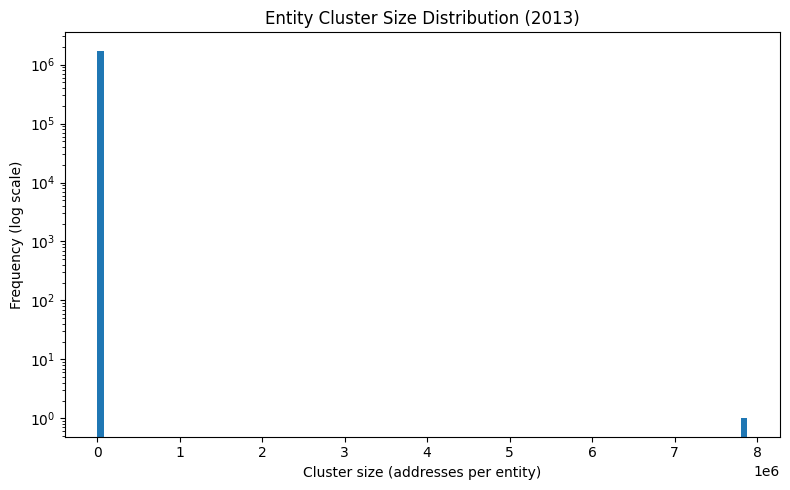

[INFO] Done.


In [ ]:
from __future__ import annotations

from pathlib import Path
from datetime import date, timedelta
from collections import Counter, defaultdict
import glob
import gc
import sqlite3

import polars as pl
import matplotlib.pyplot as plt

# -----------------------------
# Paths / config
# -----------------------------
PARQUET_DIR = Path("/media/vatereal/Main/parquet")
OUTPUT_DIR = Path("/media/vatereal/Main/outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

patterns = {
    "io": str(PARQUET_DIR / "io/day=*/io-*.parquet"),
}

pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(80)

print("Parquet file counts:", {"io": len(glob.glob(patterns["io"]))})

# -----------------------------
# Analysis window: single year
# -----------------------------
ANALYSIS_YEAR = 2013
ANALYSIS_START = date(ANALYSIS_YEAR, 1, 1)
ANALYSIS_END = date(ANALYSIS_YEAR + 1, 1, 1)  # exclusive
print(f"[INFO] Analysis window: {ANALYSIS_START} .. {ANALYSIS_END} (exclusive)")

# OPTIONAL: also index outputs from some days BEFORE ANALYSIS_START so early-year spends resolve.
# This does NOT run heuristics before ANALYSIS_START; it only preloads the outpoint DB.
OUTPOINT_DB_LOOKBACK_DAYS = 365
INDEX_START = ANALYSIS_START - timedelta(days=OUTPOINT_DB_LOOKBACK_DAYS)
print(f"[INFO] Outpoint DB preload start: {INDEX_START} .. {ANALYSIS_END} (exclusive)")

# Whether to create UF nodes for every output address (huge: makes many singletons).
# Recommended False while iterating/debugging; True if you explicitly want all output addresses mapped.
PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS = False

# For plotting, don't try to histogram if there are too many entities
MAX_ENTITIES_FOR_PLOT = 5_000_000

# SQLite outpoint index location
OUTPOINT_DB_PATH = OUTPUT_DIR / f"outpoints_{ANALYSIS_YEAR}.sqlite"
RESET_OUTPOINT_DB = True  # set False to resume using existing DB

# -----------------------------
# Helpers
# -----------------------------
def extract_day_from_path(path: str) -> date | None:
    """
    Given a path like /.../io/day=2013-05-01/io-0001.parquet
    return date(2013, 5, 1).
    """
    p = Path(path)
    for part in p.parts:
        if part.startswith("day="):
            day_str = part.split("=", 1)[1]
            try:
                return date.fromisoformat(day_str)
            except ValueError:
                return None
    return None


class UnionFind:
    def __init__(self):
        self.parent: list[int] = []
        self.rank: list[int] = []

    def make_set(self) -> int:
        idx = len(self.parent)
        self.parent.append(idx)
        self.rank.append(0)
        return idx

    def find(self, x: int) -> int:
        parent = self.parent
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(self, x: int, y: int) -> None:
        rx = self.find(x)
        ry = self.find(y)
        if rx == ry:
            return

        parent = self.parent
        rank = self.rank

        if rank[rx] < rank[ry]:
            parent[rx] = ry
        elif rank[rx] > rank[ry]:
            parent[ry] = rx
        else:
            parent[ry] = rx
            rank[rx] += 1


def addr_type(addr: str) -> str:
    """Rough address type from prefix (legacy P2PKH, P2SH, Bech32, Taproot, etc.)."""
    if addr.startswith("1"):
        return "p2pkh"
    if addr.startswith("3"):
        return "p2sh"
    if addr.startswith("bc1q"):
        return "bech32_p2wpkh"
    if addr.startswith("bc1p"):
        return "taproot"
    return "other"


def detect_coinjoin_like(n_in_utxos: int, out_values: list[float]) -> bool:
    """
    Very simple CoinJoin-ish heuristic:
    - at least 3 inputs (UTXOs)
    - at least 3 outputs
    - at least 3 outputs with exactly the same value
    """
    n_out = len(out_values)
    if n_in_utxos < 3 or n_out < 3:
        return False
    cnt = Counter(out_values)
    return max(cnt.values()) >= 3


# -----------------------------
# SQLite outpoint DB
# -----------------------------
def open_outpoint_db(db_path: Path, reset: bool) -> sqlite3.Connection:
    if reset and db_path.exists():
        db_path.unlink()

    conn = sqlite3.connect(str(db_path))
    cur = conn.cursor()

    # Speed-oriented pragmas (safe enough for local reproducible indexing)
    cur.execute("PRAGMA journal_mode=WAL;")
    cur.execute("PRAGMA synchronous=OFF;")
    cur.execute("PRAGMA temp_store=MEMORY;")
    cur.execute("PRAGMA cache_size=-2000000;")  # ~2GB cache (negative => KB)

    cur.execute(
        """
        CREATE TABLE IF NOT EXISTS outpoints (
            txid TEXT NOT NULL,
            n    INTEGER NOT NULL,
            address TEXT NOT NULL,
            PRIMARY KEY(txid, n)
        );
        """
    )
    conn.commit()
    return conn


def insert_outpoints(conn: sqlite3.Connection, rows: list[tuple[str, int, str]]) -> None:
    if not rows:
        return
    conn.executemany(
        "INSERT OR IGNORE INTO outpoints(txid, n, address) VALUES (?, ?, ?);",
        rows,
    )
    conn.commit()


def lookup_outpoints(conn: sqlite3.Connection, keys: list[tuple[str, int]]) -> dict[tuple[str, int], str]:
    """
    Lookup many (prev_txid, prev_vout_int) -> address
    Returns only hits.
    """
    if not keys:
        return {}

    cur = conn.cursor()
    out: dict[tuple[str, int], str] = {}

    # Looping SELECTs is not ideal, but is usually OK per-file. Keep it tight.
    q = "SELECT address FROM outpoints WHERE txid=? AND n=?;"
    for k in keys:
        cur.execute(q, k)
        row = cur.fetchone()
        if row is not None:
            out[k] = row[0]
    return out


# -----------------------------
# Init structures
# -----------------------------
io_paths = sorted(glob.glob(patterns["io"]))
print(f"Found {len(io_paths)} io parquet files (all years).")

# Outpoint DB connection
conn = open_outpoint_db(OUTPOINT_DB_PATH, RESET_OUTPOINT_DB)
print(f"[INFO] Outpoint DB: {OUTPOINT_DB_PATH} (reset={RESET_OUTPOINT_DB})")

uf = UnionFind()
addr_to_id: dict[str, int] = {}

# Flags indexed by node_id:
# seen_output_flags[i] == 1 if address i was ever seen as an output (vout)
# multi_change_flags[i] bit 0 -> multi-input, bit 1 -> change
seen_output_flags = bytearray()
multi_change_flags = bytearray()

# If we are NOT precreating nodes for all outputs, track seen outputs in a Python set instead
# (needed for "new change address" test without exploding node count).
seen_output_addrs: set[str] | None = None
if not PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
    seen_output_addrs = set()

# Stats
n_files_indexed = 0
n_files_analyzed = 0

n_txs_total = 0
n_txs_with_multiinput = 0
n_txs_coinjoin_flagged = 0
n_txs_with_change_detected = 0

n_prevout_lookups = 0
n_prevout_hits = 0


def ensure_flag_capacity(idx: int) -> None:
    needed = idx + 1
    cur = len(seen_output_flags)
    if cur < needed:
        delta = needed - cur
        seen_output_flags.extend(b"\x00" * delta)
        multi_change_flags.extend(b"\x00" * delta)


def get_addr_id(addr: str) -> int:
    idx = addr_to_id.get(addr)
    if idx is None:
        idx = uf.make_set()
        addr_to_id[addr] = idx
        ensure_flag_capacity(idx)
    return idx


# -----------------------------
# Main loop
# -----------------------------
for i, path in enumerate(io_paths, start=1):
    file_day = extract_day_from_path(path)
    if file_day is None:
        continue

    # We do TWO things:
    # 1) Build outpoint DB for files in [INDEX_START, ANALYSIS_END)
    # 2) Run heuristics only for files in [ANALYSIS_START, ANALYSIS_END)
    if file_day < INDEX_START or file_day >= ANALYSIS_END:
        continue

    in_analysis = (ANALYSIS_START <= file_day < ANALYSIS_END)

    if in_analysis:
        n_files_analyzed += 1
        print(f"[{n_files_analyzed}] Processing {path} (day={file_day}) ...")
    else:
        # preload-only
        n_files_indexed += 1
        if n_files_indexed <= 3:
            print(f"[preload {n_files_indexed}] Indexing outputs only: {path} (day={file_day}) ...")

    # Read required columns
    df = pl.read_parquet(
        path,
        columns=["dir", "txid", "n", "prev_txid", "prev_vout", "address", "value"],
    )

    # Normalize dir
    df = df.with_columns(
        pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir")
    )

    # Debug dir values for first analyzed file
    if in_analysis and n_files_analyzed == 1:
        dir_uniques = df.select(pl.col("dir").unique()).to_series().to_list()
        print(f"  [debug] distinct dir values in first processed file: {dir_uniques}")

    # -------------------------
    # 1) Insert OUTPUTS into outpoint DB
    # -------------------------
    out_df = (
        df.filter(pl.col("dir") == "out")
          .filter(pl.col("txid").is_not_null())
          .filter(pl.col("n").is_not_null())
          .filter(pl.col("address").is_not_null())
          .select(
              pl.col("txid"),
              pl.col("n").cast(pl.Int64, strict=False).alias("n"),
              pl.col("address"),
              pl.col("value").cast(pl.Float64, strict=False).alias("value"),
          )
    )

    if out_df.height > 0:
        # Insert (txid, n, address)
        rows = [(r[0], int(r[1]), r[2]) for r in out_df.select(["txid", "n", "address"]).iter_rows()]
        insert_outpoints(conn, rows)

        # Optionally create nodes for all output addresses (makes huge singleton universe)
        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for addr in out_df.select(pl.col("address").unique()).to_series().to_list():
                _ = get_addr_id(addr)

    # If this is preload-only, stop after indexing outputs
    if not in_analysis:
        del df, out_df
        gc.collect()
        continue

    # -------------------------
    # 2) Resolve INPUT addresses via prev outpoints
    # -------------------------
    in_df = (
        df.filter(pl.col("dir") == "in")
          .filter(pl.col("txid").is_not_null())
          .filter(pl.col("prev_txid").is_not_null())
          .filter(pl.col("prev_vout").is_not_null())
          .select(
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid"),
              pl.col("prev_vout").cast(pl.Int64, strict=False).alias("prev_n"),
          )
          .filter(pl.col("prev_n").is_not_null())
    )

    # Free df early
    del df
    gc.collect()

    # Build per-tx input counts and needed prevout keys
    input_utxo_count: dict[str, int] = defaultdict(int)
    needed_keys: list[tuple[str, int]] = []
    spend_rows: list[tuple[str, str, int]] = []

    if in_df.height > 0:
        for spend_txid, prev_txid, prev_n in in_df.iter_rows():
            prev_n_int = int(prev_n)
            input_utxo_count[spend_txid] += 1
            needed_keys.append((prev_txid, prev_n_int))
            spend_rows.append((spend_txid, prev_txid, prev_n_int))

    # Lookup prevouts in DB
    n_prevout_lookups += len(needed_keys)
    prevout_map = lookup_outpoints(conn, needed_keys)
    n_prevout_hits += len(prevout_map)

    # Build input address sets by spending txid (only resolved addresses)
    inputs_by_txid: dict[str, set[str]] = defaultdict(set)
    for spend_txid, prev_txid, prev_n_int in spend_rows:
        addr = prevout_map.get((prev_txid, prev_n_int))
        if addr:
            inputs_by_txid[spend_txid].add(addr)

    # -------------------------
    # 3) Group outputs per tx and run heuristics
    # -------------------------
    if out_df.height == 0:
        del out_df, in_df, inputs_by_txid, input_utxo_count, prevout_map, needed_keys, spend_rows
        gc.collect()
        continue

    vout_grouped = (
        out_df.group_by("txid")
              .agg(
                  pl.col("address").alias("out_addrs"),
                  pl.col("value").alias("out_values"),
              )
    )

    del out_df, in_df
    gc.collect()

    if vout_grouped.height == 0:
        del vout_grouped, inputs_by_txid, input_utxo_count, prevout_map, needed_keys, spend_rows
        gc.collect()
        continue

    for row in vout_grouped.iter_rows(named=True):
        txid: str = row["txid"]
        out_addrs: list[str] = row["out_addrs"]
        out_values: list[float] = row["out_values"]

        if not out_addrs:
            continue

        n_in_utxos = input_utxo_count.get(txid, 0)
        if n_in_utxos == 0:
            # Can't do vin/vout heuristics without any inputs for this tx
            # (either no inputs in this file, or none resolved)
            continue

        n_txs_total += 1

        # CoinJoin-like: use n_in_utxos (count of input outpoints), not resolved unique addrs
        is_coinjoin = detect_coinjoin_like(n_in_utxos, out_values)
        if is_coinjoin:
            n_txs_coinjoin_flagged += 1
            # mark outputs as seen
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a in out_addrs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a in out_addrs:
                    if a is not None:
                        seen_output_addrs.add(a)
            continue

        in_addrs_set = inputs_by_txid.get(txid)
        if not in_addrs_set:
            # Inputs exist but none resolved -> can’t cluster
            # Still mark outputs seen.
            if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                for a in out_addrs:
                    if a is None:
                        continue
                    a_id = get_addr_id(a)
                    seen_output_flags[a_id] = 1
            else:
                for a in out_addrs:
                    if a is not None:
                        seen_output_addrs.add(a)
            continue

        in_addrs = list(in_addrs_set)
        n_out = len(out_addrs)

        # --- Multi-input heuristic (use UTXO-count threshold, union resolved unique addresses) ---
        if n_in_utxos >= 2:
            n_txs_with_multiinput += 1
            if len(in_addrs) >= 2:
                in_ids = [get_addr_id(a) for a in in_addrs]
                for idx in in_ids:
                    multi_change_flags[idx] |= 1

                first_id = in_ids[0]
                for idx in in_ids[1:]:
                    uf.union(first_id, idx)
            else:
                # Only 1 unique resolved address; still mark it as participating in multi-input txs
                idx = get_addr_id(in_addrs[0])
                multi_change_flags[idx] |= 1

        # --- Change heuristic ---
        if n_in_utxos >= 1 and n_out >= 2 and in_addrs:
            in_types = [addr_type(a) for a in in_addrs]
            type_counts = Counter(in_types)
            majority_type = max(type_counts, key=type_counts.get)

            candidates: list[str] = []
            in_addr_set_fast = set(in_addrs)

            for a in out_addrs:
                if a is None:
                    continue
                if a in in_addr_set_fast:
                    continue
                if addr_type(a) != majority_type:
                    continue

                # "New output address" test:
                if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
                    a_id = get_addr_id(a)
                    if seen_output_flags[a_id]:
                        continue
                else:
                    if a in seen_output_addrs:
                        continue

                candidates.append(a)

            if len(candidates) == 1:
                change_addr = candidates[0]
                change_id = get_addr_id(change_addr)
                multi_change_flags[change_id] |= 2
                n_txs_with_change_detected += 1

                first_input_id = get_addr_id(in_addrs[0])
                uf.union(first_input_id, change_id)

        # mark outputs as seen (for future change detection)
        if PRECREATE_NODES_FOR_ALL_OUTPUT_ADDRS:
            for a in out_addrs:
                if a is None:
                    continue
                a_id = get_addr_id(a)
                seen_output_flags[a_id] = 1
        else:
            for a in out_addrs:
                if a is not None:
                    seen_output_addrs.add(a)

    del vout_grouped, inputs_by_txid, input_utxo_count, prevout_map, needed_keys, spend_rows
    gc.collect()


# -----------------------------
# Finalize entity mapping
# -----------------------------
print("Finalizing entity mapping (compressing components)...")

n_nodes = len(addr_to_id)
print(f"Number of unique addresses with UF nodes: {n_nodes}")

print(f"[INFO] prevout lookups: {n_prevout_lookups:,}  hits: {n_prevout_hits:,}  hit-rate: {(n_prevout_hits / max(1, n_prevout_lookups)):.3%}")

if n_nodes == 0:
    print("No union-find nodes created. This means no input addresses were resolved (or heuristics never triggered).")
else:
    node_to_entity = [0] * n_nodes
    root_to_entity: dict[int, int] = {}
    next_entity_id = 0

    for node in range(n_nodes):
        root = uf.find(node)
        ent = root_to_entity.get(root)
        if ent is None:
            ent = next_entity_id
            root_to_entity[root] = ent
            next_entity_id += 1
        node_to_entity[node] = ent

    print(f"Number of entities (clusters): {next_entity_id}")

    # Build output mapping DF
    addresses_out: list[str] = []
    entity_ids_out: list[int] = []
    for addr, node_id in addr_to_id.items():
        addresses_out.append(addr)
        entity_ids_out.append(node_to_entity[node_id])

    entities_df = pl.DataFrame({"address": addresses_out, "entity_id": entity_ids_out})

    out_path = OUTPUT_DIR / f"entities_multiinput_change_{ANALYSIS_YEAR}.parquet"
    entities_df.write_parquet(out_path)
    print(f"Saved entity mapping to: {out_path}")

    # -----------------------------
    # Stats & plots
    # -----------------------------
    cluster_size_counter = Counter(node_to_entity)
    n_entities = len(cluster_size_counter)

    if n_entities <= MAX_ENTITIES_FOR_PLOT:
        cluster_sizes = list(cluster_size_counter.values())
        n_singletons = sum(1 for s in cluster_sizes if s == 1)
        n_large = sum(1 for s in cluster_sizes if s >= 10)
    else:
        cluster_sizes = None
        n_singletons = sum(1 for s in cluster_size_counter.values() if s == 1)
        n_large = sum(1 for s in cluster_size_counter.values() if s >= 10)

    flags_view = multi_change_flags[:n_nodes]
    n_addrs_multi = sum(1 for v in flags_view if (v & 1))
    n_addrs_change = sum(1 for v in flags_view if (v & 2))
    n_addrs_touched = sum(1 for v in flags_view if (v & 3))

    print("\nHeuristic coverage (node-level):")
    print(f"  Total txs processed (with outputs + >=1 input UTXO): {n_txs_total}")
    print(f"  Txs flagged as CoinJoin-like (skipped): {n_txs_coinjoin_flagged}")
    print(f"  Txs with multi-input heuristic (>=2 input UTXOs): {n_txs_with_multiinput}")
    print(f"  Txs with change detected: {n_txs_with_change_detected}")
    print(f"  Addresses marked multi-input (unique nodes): {n_addrs_multi}")
    print(f"  Addresses marked change (unique nodes): {n_addrs_change}")
    print(f"  Addresses touched by any heuristic (unique nodes): {n_addrs_touched}")

    print("\nCluster stats:")
    print(f"  Total entities: {n_entities}")
    print(f"  Singleton entities (size=1): {n_singletons}")
    print(f"  Entities with size >= 10: {n_large}")

    if cluster_sizes is not None and any(s > 0 for s in cluster_sizes):
        plt.figure(figsize=(8, 5))
        plt.hist(cluster_sizes, bins=100, log=True)
        plt.xlabel("Cluster size (addresses per entity)")
        plt.ylabel("Frequency (log scale)")
        plt.title(f"Entity Cluster Size Distribution ({ANALYSIS_YEAR})")
        plt.tight_layout()
        plt.show()
        plt.close()
    elif cluster_sizes is None:
        print(f"Skipping cluster size histogram (too many entities > {MAX_ENTITIES_FOR_PLOT}).")

# Close DB
conn.close()
print("[INFO] Done.")


In [6]:
# -----------------------------
# Sanity checks (drop-in code)
# -----------------------------
# Assumes you already computed:
#   - n_nodes (int): number of UF nodes / unique addresses created
#   - node_to_entity (list[int]) OR cluster_size_counter (Counter[int])
# Optional (prevout hit-rate):
#   - prevout_lookups (int)
#   - prevout_hits (int)

from collections import Counter
import math

def run_sanity_checks(
    n_nodes: int,
    node_to_entity: list[int] | None = None,
    cluster_size_counter: Counter | None = None,
    prevout_lookups: int | None = None,
    prevout_hits: int | None = None,
    top_k: int = 20,
) -> None:
    """
    Prints:
      - largest cluster fraction of nodes
      - top cluster sizes
      - entity count stats
      - optional prevout hit-rate
    Provide either node_to_entity OR cluster_size_counter.
    """
    if cluster_size_counter is None:
        if node_to_entity is None:
            raise ValueError("Provide either node_to_entity or cluster_size_counter.")
        cluster_size_counter = Counter(node_to_entity)

    sizes = list(cluster_size_counter.values())
    if not sizes:
        print("[SANITY] No clusters found (sizes empty).")
        return

    sizes_sorted = sorted(sizes, reverse=True)
    total_nodes_from_sizes = sum(sizes_sorted)
    largest = sizes_sorted[0]
    frac = largest / total_nodes_from_sizes if total_nodes_from_sizes else float("nan")

    print("\n[SANITY] Cluster summary")
    print(f"  UF nodes (n_nodes): {n_nodes}")
    print(f"  Total nodes from cluster sizes: {total_nodes_from_sizes}")
    if total_nodes_from_sizes != n_nodes:
        print("  [WARN] sum(cluster_sizes) != n_nodes  -> mismatch suggests a bug in mapping logic.")
    print(f"  Entities (clusters): {len(cluster_size_counter)}")
    print(f"  Largest cluster size: {largest}")
    print(f"  Largest cluster fraction of nodes: {frac:.2%}")

    print(f"\n[SANITY] Top {top_k} cluster sizes:")
    print(" ", sizes_sorted[:top_k])

    # A couple more helpful distribution points
    def pct(p: float) -> int:
        # nearest-rank percentile
        if not sizes_sorted:
            return 0
        idx = max(0, min(len(sizes_sorted) - 1, math.ceil(p * len(sizes_sorted)) - 1))
        return sorted(sizes_sorted)[idx]

    med = sorted(sizes_sorted)[len(sizes_sorted) // 2]
    print("\n[SANITY] Quick distribution stats")
    print(f"  Median cluster size: {med}")
    print(f"  90th percentile cluster size: {pct(0.90)}")
    print(f"  99th percentile cluster size: {pct(0.99)}")

    if prevout_lookups is not None and prevout_hits is not None:
        rate = (prevout_hits / prevout_lookups) if prevout_lookups else float("nan")
        print("\n[SANITY] Prevout lookup hit-rate")
        print(f"  Lookups: {prevout_lookups}")
        print(f"  Hits:    {prevout_hits}")
        print(f"  Hit-rate: {rate:.2%}")



run_sanity_checks(
     n_nodes=n_nodes,
     node_to_entity=node_to_entity,
 )

# Option B: if you already built Counter(node_to_entity) as cluster_size_counter
# run_sanity_checks(
#     n_nodes=n_nodes,
#     cluster_size_counter=cluster_size_counter,
#     prevout_lookups=prevout_lookups,   # if you track these
#     prevout_hits=prevout_hits,         # if you track these
# )



[SANITY] Cluster summary
  UF nodes (n_nodes): 14291976
  Total nodes from cluster sizes: 14291976
  Entities (clusters): 1720337
  Largest cluster size: 7883239
  Largest cluster fraction of nodes: 55.16%

[SANITY] Top 20 cluster sizes:
  [7883239, 62912, 23467, 13000, 10394, 9882, 9792, 8781, 7194, 5404, 4332, 3422, 3381, 3165, 2988, 2697, 2575, 2429, 2398, 2269]

[SANITY] Quick distribution stats
  Median cluster size: 2
  90th percentile cluster size: 6
  99th percentile cluster size: 23


In [8]:
from pathlib import Path
import polars as pl

OUTPUT_DIR_VALUES = {"out", "vout", "output", "o"}
INPUT_DIR_VALUES  = {"in", "vin", "input", "i"}

def prevout_join_sanity(one_io_parquet: str) -> None:
    df = pl.read_parquet(one_io_parquet, columns=["dir","txid","n","prev_txid","prev_vout","address","value"])

    df = df.with_columns(
        pl.col("dir").cast(pl.Utf8).str.to_lowercase().alias("dir")
    )

    vout = (
        df.filter(pl.col("dir").is_in(list(OUTPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("out_txid"),
              pl.col("n").cast(pl.Int64).alias("out_n"),
              pl.col("address").alias("out_address"),
              pl.col("value").alias("out_value"),
          ])
    )

    vin = (
        df.filter(pl.col("dir").is_in(list(INPUT_DIR_VALUES)))
          .select([
              pl.col("txid").alias("spend_txid"),
              pl.col("prev_txid").alias("prev_txid"),
              pl.col("prev_vout").alias("prev_vout"),
          ])
    )

    print("Rows:", {"vin": vin.height, "vout": vout.height})

    # 1) Check prev_vout is integer-like (Float64 in your schema is suspicious)
    vin_nonnull = vin.filter(pl.col("prev_vout").is_not_null())
    if vin_nonnull.height > 0:
        frac_integerlike = (
            vin_nonnull
            .with_columns(((pl.col("prev_vout") - pl.col("prev_vout").floor()).abs() < 1e-9).alias("is_intlike"))
            .select(pl.col("is_intlike").mean())
            .item()
        )
        print(f"prev_vout integer-like fraction: {frac_integerlike:.6f}")

    # Cast prev_vout safely to int for joining
    vin2 = vin.with_columns(
        pl.when(pl.col("prev_vout").is_not_null())
          .then(pl.col("prev_vout").cast(pl.Int64))
          .otherwise(None)
          .alias("prev_vout_i64")
    )

    # 2) Check uniqueness of outpoints (out_txid, out_n) should be unique
    dupe_outpoints = (
        vout.group_by(["out_txid","out_n"])
            .len()
            .filter(pl.col("len") > 1)
            .height
    )
    print("Duplicate outpoints (should be 0):", dupe_outpoints)

    # 3) Join vin prevouts -> vout outpoints
    joined = (
        vin2.join(
            vout,
            left_on=["prev_txid","prev_vout_i64"],
            right_on=["out_txid","out_n"],
            how="left",
        )
    )

    resolved = joined.filter(pl.col("out_address").is_not_null()).height
    lookups  = vin.height
    print(f"Prevout resolution hit-rate: {resolved}/{lookups} = {resolved/lookups:.2%}" if lookups else "No vin rows")

    # 4) Check for join explosion: each input should match <= 1 output
    max_matches_per_input = (
        joined.group_by(["spend_txid","prev_txid","prev_vout_i64"])
              .len()
              .select(pl.col("len").max())
              .item()
    )
    print("Max matches per (spend_txid, prev_txid, prev_vout):", max_matches_per_input)

    # Optional: show some unresolved examples
    sample_unresolved = (
        joined.filter(pl.col("out_address").is_null())
              .select(["spend_txid","prev_txid","prev_vout_i64"])
              .head(5)
    )
    print("\nSample unresolved inputs:")
    print(sample_unresolved)


prevout_join_sanity("/media/vatereal/Main/parquet/io/day=2013-01-01/io-....parquet")


FileNotFoundError: No such file or directory (os error 2): /media/vatereal/Main/parquet/io/day=2013-01-01/io-....parquet

This error occurred with the following context stack:
	[1] 'parquet scan'
	[2] 'select'
	[3] 'sink'
